In this notebook, i demonstrate the issue of correlated in transit detetction. By simulating light curve containing a transit with increasing level of red noise (varying its std as well as the parmaetres of variability such as rotation period). I choose to keep a very general unphysical approach wehere transit signal is modeled with a protopapas model.

In [32]:
import numpy as np
import sys
import matplotlib.pyplot as plt
import jax
jax.config.update("jax_enable_x64", True)

# from scripts
# ------------
from nuance.utils import transit
np.random.seed(43)

fluxes = []
snrs = []

# A transit without noise

In [2]:
# transit
time = np.linspace(0, 3, 1000)
dur = 0.1
depth = 0.8e-2
n = dur/np.median(np.diff(time))
signal = transit(time, time.mean(), dur, depth, c=10) + 1.

# white noise
wsigma = 1.5e-3
white_noise = np.random.normal(0, wsigma, len(time))
flux = white_noise + signal

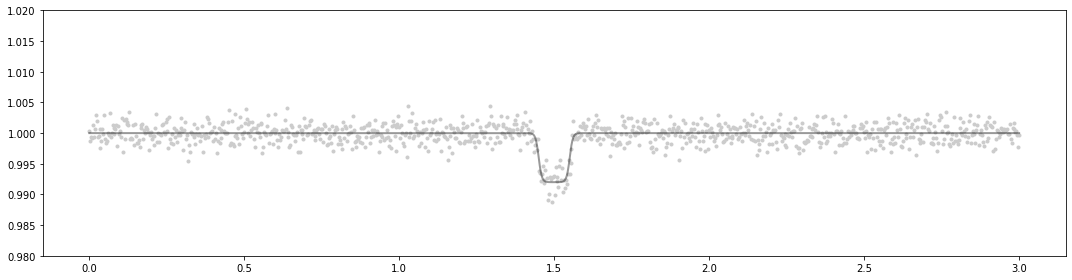

In [3]:
plt.figure(figsize=(15,4))
plt.plot(time, flux, ".", c="0.8")
plt.plot(time, signal, c="k", alpha=0.4, lw=2)
plt.ylim(0.98, 1.02)
plt.tight_layout()

In [4]:
import jax, jaxopt
import pandas as pd
import numpy as np
import jax.numpy as jnp
from tinygp import kernels, GaussianProcess
import matplotlib.pyplot as plt


def white_red(time, flux, error, plot=False, mean=0.):
    init = {
        "log_diag": 2*np.log(np.mean(error)),
        "log_scale": np.log(1), # 5 mins
        "log_amp": np.log(np.std(flux))
    }

    def build_gp(params):
        kernel = jnp.exp(params["log_amp"]) * kernels.ExpSquared(jnp.exp(params["log_scale"]))
        return GaussianProcess(kernel, time, diag=jnp.exp(params["log_diag"]), mean=mean)

    @jax.jit
    def loss(params):
        gp = build_gp(params)
        return -gp.log_probability(flux)
    
    opt = jaxopt.ScipyMinimize(fun=loss)
    params = opt.run(init).params  
    w = np.sqrt(np.exp(params['log_diag']))
    
    if plot:
        gp = build_gp(params)
        _, cond = gp.condition(y=flux, X_test=time)
        mu = cond.mean
        plt.plot(time, flux, ".", c="0.8")
        plt.plot(time, mu, c="k")
        noise = w
        plt.fill_between(time, mu + noise, mu - noise, color="C0", alpha=0.3)

    return w, np.sqrt(np.exp(params['log_amp']))

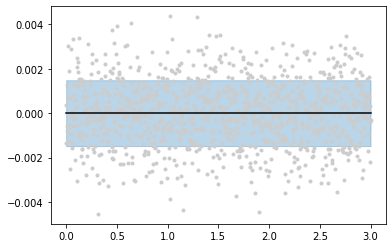

In [5]:
w, r = white_red(time, flux-signal, wsigma, plot=True)
SNR = depth/np.sqrt((w**2)/n + r**2)

In [6]:
w, r = white_red(time, flux-signal, wsigma, plot=True)
SNR = depth/np.sqrt((w**2)/n + r**2)

fluxes.append(flux.copy())
snrs.append(SNR.copy())

# Adding some red noise

In [7]:
import tinygp

In [8]:
kernel = tinygp.kernels.quasisep.Matern32(0.1, 1.5e-3)
gp = tinygp.GaussianProcess(kernel, time, diag=0., mean=0.)
red_noise = gp.sample(jax.random.PRNGKey(42))
flux =  white_noise + red_noise + signal

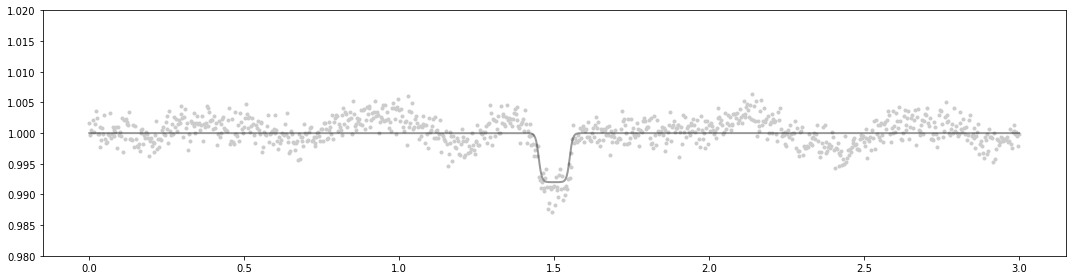

In [9]:
plt.figure(figsize=(15,4))
plt.plot(time, flux, ".", c="0.8")
plt.plot(time, signal, c="k", alpha=0.4, lw=2)
plt.ylim(0.98, 1.02)
plt.tight_layout()

In [10]:
w, r = white_red(time, flux-signal, wsigma)
SNR = depth/np.sqrt((w**2)/n + r**2)
print(f"SNR: {SNR}")

SNR: 5.421376911587421


In [11]:
fluxes.append(flux.copy())
snrs.append(SNR.copy())

# Adding some variability

In [12]:
var_kernel = tinygp.kernels.quasisep.SHO(10, 3, 0.4e-2)
gp = tinygp.GaussianProcess(var_kernel, time, diag=0., mean=0.)
variability = gp.sample(jax.random.PRNGKey(43))

flux = white_noise + red_noise + signal + variability

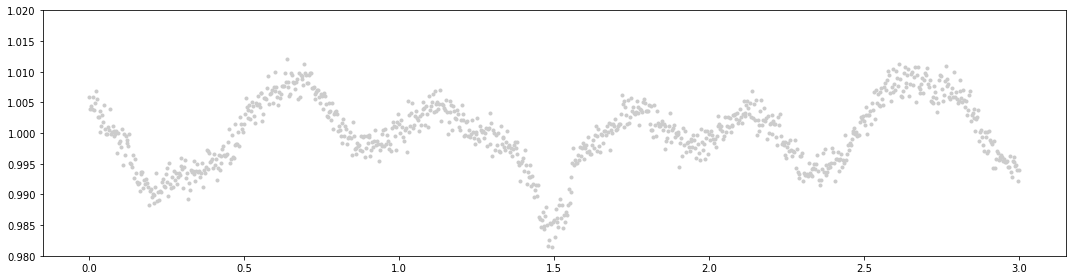

In [13]:
plt.figure(figsize=(15,4))
plt.plot(time, flux, ".", c="0.8")
plt.ylim(0.98, 1.02)
plt.tight_layout()

SNR: 1.7155019395211824


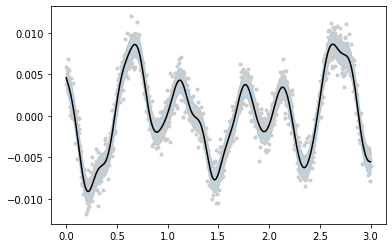

In [14]:
w, r = white_red(time, flux-signal, wsigma, plot=True)
SNR = depth/np.sqrt((w**2)/n + r**2)
print(f"SNR: {SNR}")

In [15]:
fluxes.append(flux.copy())
snrs.append(SNR.copy())

# Nice plot

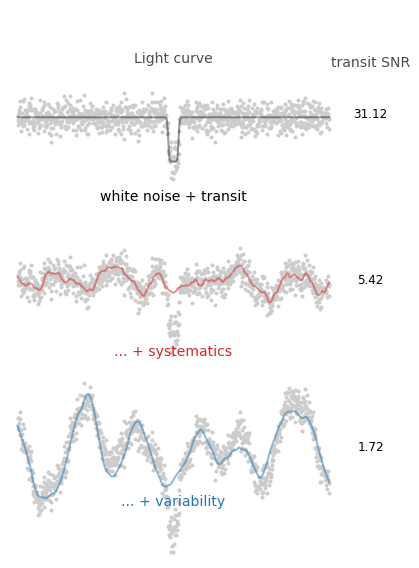

In [16]:
plt.figure(figsize=(6,8))
offset = 0.03

plt.text(3.4, 1.01, f"transit SNR", ha="center", fontsize=14, alpha=0.7, va="center")
plt.text(time.mean(), 1.01, f"Light curve", ha="center", fontsize=14, alpha=0.7)


plt.plot(time, fluxes[0], ".", c="0.8")
plt.plot(time, signal, c="k", alpha=0.4, lw=2)
plt.text(time.mean(), 0.985, "white noise + transit", ha="center", fontsize=14)
plt.text(3.4, 1, f"{snrs[0]:.2f}", ha="center", fontsize=12)

plt.plot(time, fluxes[1] - offset, ".", c="0.8")
plt.plot(time, red_noise + 1 - offset, c="C3", alpha=0.5, lw=2)
plt.text(time.mean(), 0.987 - offset, "... + systematics", ha="center", fontsize=14, c="C3")
plt.text(3.4, 1 - offset, f"{snrs[1]:.2f}", ha="center", fontsize=12)

plt.plot(time, fluxes[2] - 2*offset, ".", c="0.8")
#plt.plot(time, signal - 2*offset, c="k", alpha=0.4, lw=2)
#plt.plot(time, red_noise + 1 - 2*offset, c="C3", alpha=0.5, lw=2)
plt.plot(time, variability + 1 - 2*offset, c="C0", alpha=0.5, lw=2)
plt.text(time.mean(), 0.99 - 2*offset, "... + variability", ha="center", fontsize=14, c="C0")
plt.text(3.4, 1 - 2*offset, f"{snrs[2]:.2f}", ha="center", fontsize=12)

plt.ylim(0.92, 1.02)
plt.xlim(-0.1, 3.8)
plt.axis("off")
plt.tight_layout()
#plt.savefig("../../figures/first_issue.pdf")

This first issue is well known by the community (e.g. \citealt{}) and is commonly delt with using a \textit{two-step} approach: cleaning the signal from any correlated noise first, and then seaching for transits assuming only uncorrelated noise remains (e.g. \citealt{}). This can be done empirically, through the use of sliding window filtering (e.g.) or analytically, using a combinaison of instrumental and stellar varibility models (e.g.). In any case, cleaning the signal from an incomplete model, one that do not contain a transit signal, lead to the degradation of the transit signal considered in the second step. 

In figure, we generate a range of transit light curves in the presence of photometric variability and use the wotan Python package (... whcih provide ...) to remove the variability component from these signals in an optimal way. We show for each light curve the extent of the transit signal degradation by evaluating the remaining transit depth, yielding a degradation of its SNR. This figure highlights that the degradation of the transit signal isn't homogenous and is highly dependant on the nature of the correlated noise considered. This point will be developped in more details in section{}

An alternative to the two-step approach is to search for transits by doing a full-fledge modeling of the light curve signal.


# Cleaning with wotan

In [17]:
from wotan import flatten
# https://github.com/hippke/wotan

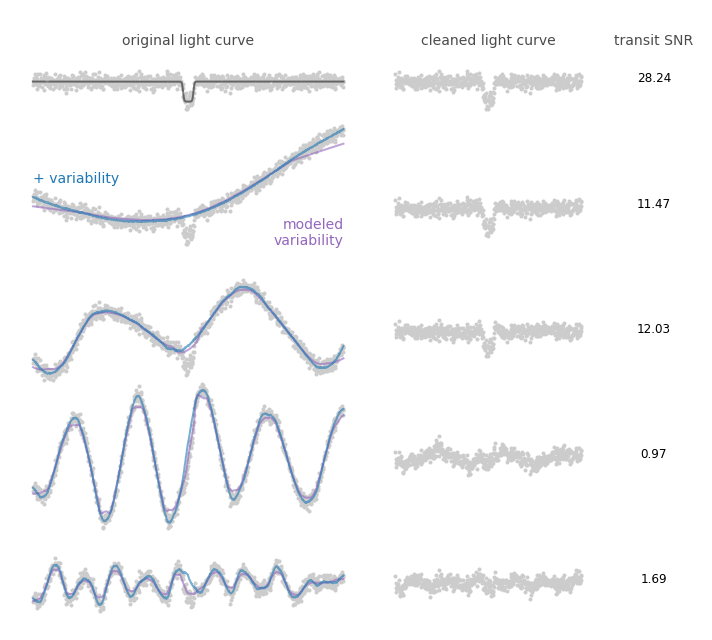

In [27]:
np.random.seed(47)
plt.figure(figsize=(10,9))

periods = [100., 1., 0.2, 0.1, 0.05]
amps = [0., 1e-2, 1e-2, 1e-2, 5e-3]
window_lengths = [2, 1, 0.3, 0.2, 0.15]
offset = 0.05

for i, (period, amp) in enumerate(zip(periods, amps)):
    Q = 10.
    w0 = 1/period
    S0 = amp

    var_kernel = tinygp.kernels.quasisep.SHO(w0, Q, S0)
    gp = tinygp.GaussianProcess(var_kernel, time, mean=0.)
    _variability = gp.sample(jax.random.PRNGKey(41))
    _variability -= np.median(_variability)
    _flux = white_noise + signal + _variability
    plt.plot(time, _flux - offset*i, ".", c="0.8")
    if i==0:
        plt.plot(time,signal - offset*i, c="k", alpha=0.5, lw=2)
    
    cut = 200
    _flatten_flux, _flatten_trend = flatten(time, _flux, window_length=window_lengths[i], return_trend=True)
    plt.plot(time[cut:-cut] + np.max(time) - 0.1, _flatten_flux[cut:-cut] - offset*i, ".", c="0.8")
    
    if i!=0:
        plt.plot(time, _flatten_trend - offset*i, c="C4", alpha=0.6, lw=2)
        plt.plot(time, _variability + 1 - offset*i, c="C0", alpha=0.6, lw=2)
    
    intransit = signal < (1. - depth/2)
    new_depth = np.max([0, np.mean(_flatten_flux[~intransit][cut:-cut]) - np.mean(_flatten_flux[intransit])])
    w, r = white_red(time[~intransit][cut:-cut], _flatten_flux[~intransit][cut:-cut], wsigma, mean=np.median(_flatten_flux))
    new_SNR = new_depth/np.sqrt((w**2)/n + r**2)
    plt.text(6, 1 - i*offset, f"{new_SNR:.2f}", ha="center", fontsize=12)

plt.text(time.mean(), 1.015, "original light curve", ha="center", fontsize=14, alpha=0.7)
plt.text(np.mean(time[cut:-cut] + np.max(time) - 0.1), 1.015, "cleaned light curve", ha="center", fontsize=14, alpha=0.7)
plt.text(time.min(), 1.01 - offset, "+ variability", ha="left", fontsize=14, alpha=1, c="C0")
plt.text(time.max(), 1.01 - 1.5*offset, "modeled\nvariability", ha="right", fontsize=14, alpha=1, c="C4")
plt.text(6, 1.015, "transit SNR", ha="center", fontsize=14, alpha=0.7)


plt.xlim(-0.25, 6.5)
plt.ylim(0.78, 1.03)
plt.axis("off")
plt.tight_layout()
#plt.savefig("../../figures/second_issue.pdf")

# Cleaning with the same Gaussian Process

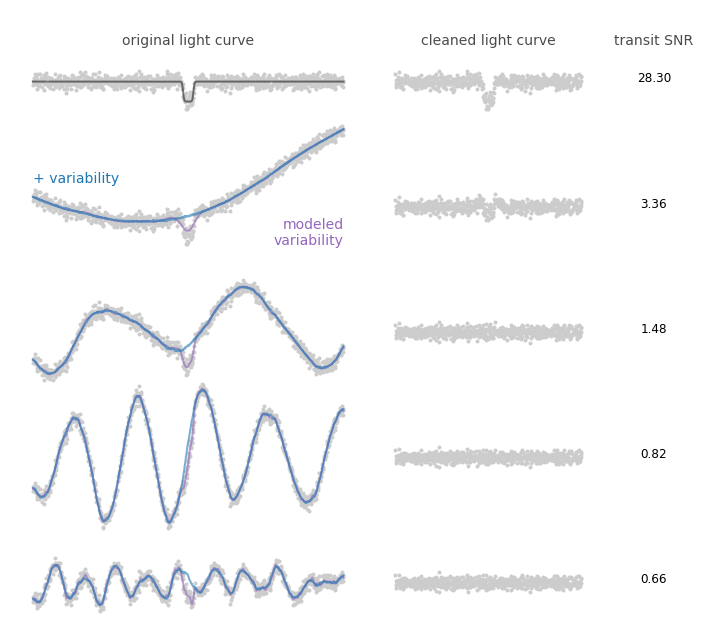

In [31]:
np.random.seed(47)
plt.figure(figsize=(10,9))

for i, (period, amp) in enumerate(zip(periods, amps)):
    Q = 10.
    w0 = 1/period
    S0 = amp

    var_kernel = tinygp.kernels.quasisep.SHO(w0, Q, S0)
    gp = tinygp.GaussianProcess(var_kernel, time, mean=0.)
    _variability = gp.sample(jax.random.PRNGKey(41))
    _variability -= np.median(_variability)
    _flux = white_noise + signal + _variability
    plt.plot(time, _flux - offset*i, ".", c="0.8")
    if i==0:
        plt.plot(time,signal - offset*i, c="k", alpha=0.5, lw=2)
    
    cut = 200
    _, cond = gp.condition(y=_flux-1., X_test=time)
    variability_model = cond.mean + 1.
    _flatten_flux = _flux - variability_model + 1.
    plt.plot(time[cut:-cut] + np.max(time) - 0.1, _flatten_flux[cut:-cut] - offset*i, ".", c="0.8")
    
    if i!=0:
        plt.plot(time, variability_model - offset*i, c="C4", alpha=0.6, lw=2)
        plt.plot(time, _variability + 1 - offset*i, c="C0", alpha=0.6, lw=2)
    
    intransit = signal < (1. - depth/2)
    new_depth = np.max([0, np.mean(_flatten_flux[~intransit][cut:-cut]) - np.mean(_flatten_flux[intransit])])
    w, r = white_red(time[~intransit][cut:-cut], _flatten_flux[~intransit][cut:-cut], wsigma, mean=np.median(_flatten_flux))
    new_SNR = new_depth/np.sqrt((w**2)/n + r**2)
    plt.text(6, 1 - i*offset, f"{new_SNR:.2f}", ha="center", fontsize=12)

plt.text(time.mean(), 1.015, "original light curve", ha="center", fontsize=14, alpha=0.7)
plt.text(np.mean(time[cut:-cut] + np.max(time) - 0.1), 1.015, "cleaned light curve", ha="center", fontsize=14, alpha=0.7)
plt.text(time.min(), 1.01 - offset, "+ variability", ha="left", fontsize=14, alpha=1, c="C0")
plt.text(time.max(), 1.01 - 1.5*offset, "modeled\nvariability", ha="right", fontsize=14, alpha=1, c="C4")
plt.text(6, 1.015, "transit SNR", ha="center", fontsize=14, alpha=0.7)


plt.xlim(-0.25, 6.5)
plt.ylim(0.78, 1.03)
plt.axis("off")
plt.tight_layout()
plt.savefig("../../figures/second_issue.pdf")